**Link Prediction**: A network is changing overtime, given a snapshort at the time $t$, predict edges added in time $(t,t')$      
**Link Completion(missing links identification)**: Given a network, infer links that are consistent with structure, but missing(find unobserved edges).    
**Link reliability**: Estimate reliablility of links in give networks.    

*Predictions: Link existence, link type, link weight*

### Link Prediction by proximity scoring
- For each pair of nodes, compute proximity (similarity) score $c(v1,v2).$
- Sort all pari by descending order.
- Select top n (or some threshold) as new links

*Proximities*

- Number of common neighbors
<center>$|N(v_{i})\cap N(v_{j})|$</center>

- Jaccard coefficient
<center>$\frac{|N(v_{i})\cap N(v_{j})|} {|N(v_{i})\cup N(v_{j})|} $</center>

- Adamic/ Adar
<center>
$\sum\limits_{v \in N(v_{i})\cap N(v_{j})} \frac{1}{\log |N(v)|}$
</center>



In [0]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy.spatial.distance as spt
import itertools
import math

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from collections import OrderedDict
%matplotlib inline
# plt.xkcd()

In [0]:
def pred_edges_w_score(G,
                       sim_method = 'jaccard', 
                       predict_method = 'thresh', 
                       thresh = 0.6, 
                       n_top = 4,
                       plot = True,
                       pos = None):
    
    '''
        Predict edges according to scoring
        
        Parameters:
        --------
            G: networkx graph
            sim_method: distance method used for computing, 
                check scipy.spatial.distance.pdist function for reference
            predict_method: 'thresh' or 'n_largest' predict with threshold or pick up n largest 
            thresh: threshold used for prediction
            n_top: number of predicted new edges, if picking n_largest
            plot: boolean, plot generated edges if True
            pos: graph plotting layout

        Returns:
            Predicted list of edges (list of lists)
    '''

    # adjacency matrix
    A = nx.to_numpy_array(G)

    # similarity, converted to matrix
    sim = 1 - spt.pdist(A,metric = sim_method)
    sim = spt.squareform(sim)

    # thresholding
    if predict_method == 'thresh':
        locs = np.where(sim >= thresh)
        added_edges = list(zip(locs[0],locs[1]))
        added_edges = np.sort(added_edges,axis = -1).tolist()
        added_edges.sort()
        added_edges = [list(edge) for edge, _ in itertools.groupby(added_edges)]

    # picking most likely edges
    elif predict_method == 'n_largest':
        ind = np.argpartition(sim, -n_top*2,axis = None)[-n_top*2:]
        locs = np.unravel_index(ind, sim.shape)
        added_edges = list(zip(locs[0],locs[1]))

        # remove duplicates, u-v,v-u only retain one
        added_edges = np.sort(added_edges,axis = -1).tolist()
        added_edges.sort()
        added_edges = [list(edge) for edge, _ in itertools.groupby(added_edges)][:n_top]

    # plot
    if plot:
        if pos is None:
            pos = nx.spring_layout(G)

        with plt.xkcd():
            nx.draw(G,node_size = 1500,with_labels = True,cmap = 'Set2',alpha = 0.9,pos = pos)
            nx.draw_networkx_edges(G,pos,added_edges,edge_color = 'darkred',width = 5)
            plt.show()

    return added_edges

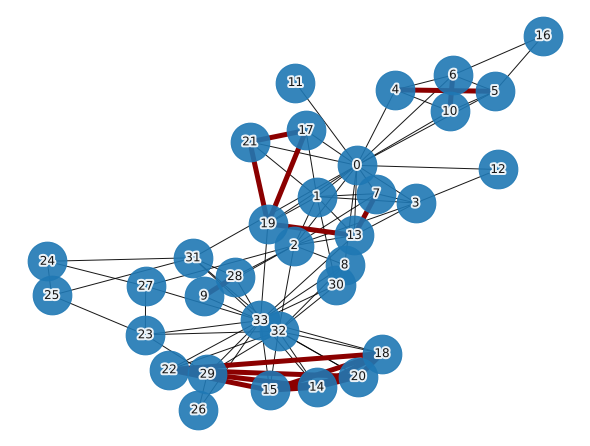

[[4, 5],
 [6, 10],
 [7, 13],
 [9, 28],
 [13, 19],
 [14, 15],
 [14, 18],
 [14, 20],
 [14, 22],
 [15, 18],
 [15, 20],
 [15, 22],
 [17, 19],
 [17, 21],
 [18, 20],
 [18, 22],
 [19, 21],
 [20, 22]]

In [5]:
G = nx.erdos_renyi_graph(20,0.2)
G = nx.karate_club_graph()

figsize(8,6)
pos = nx.spring_layout(G)

added_edges = pred_edges_w_score(G, 
              sim_method = 'jaccard', 
              predict_method = 'thresh', 
              thresh = .6, 
              n_top = 4,
              plot = True,
              pos = pos)
added_edges

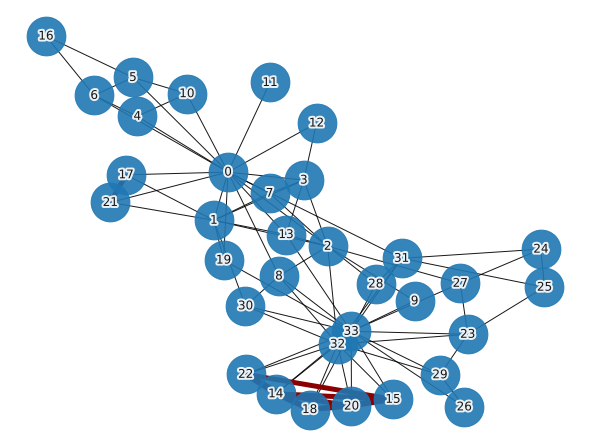

[[14, 15],
 [14, 18],
 [14, 20],
 [14, 22],
 [15, 18],
 [15, 20],
 [15, 22],
 [17, 21],
 [18, 20],
 [18, 22]]

In [6]:
added_edges = pred_edges_w_score(G, 
              sim_method = 'jaccard', 
              predict_method = 'n_largest', 
              thresh = .4,
              n_top = 10,
              plot = True,
)
added_edges

*Similarity measures tend to predict in-cluster edges*

In [0]:
def common_neighbors(G = None,i = None,j = None,A = None):

    '''
        Find common neighbors

        Parameters:
        --------
            G: networkx graph
            i,j: node to find common neighbors
            A: adjacency matrix

        Returns:
            list of common neighbors

    '''
    if A is None and G is None:
        raise Exception('Unspecified Graph')
    
    if A is None:
        A = nx.to_numpy_array(G)

    if i is None or j is None:
        return ((i,  j, np.nonzero(A[i,:] * A[j,:])[0].tolist()) for i in range(A.shape[0]) for j in range(i,A.shape[0]))

    else:
        return np.nonzero(A[i,:] * A[j,:])[0].tolist()

def adamic_adar_predict(G,thresh = 1,n_top = 5,predict_method = 'thresh'):

    '''
        Predict edges using adamic scoring
        Parameters:
        ------
            G: networkx graph
            thresh: thresholding value
            n_top: number of edges to retrieve
            predict_method: 'thresh' or 'n_largest

        Returns:
        ------
            Predicted edgelistt
    '''

    A = nx.to_numpy_array(G)
    sim = dict()
    for u,v in nx.non_edges(G):
        sim[(u,v)] = sum(1. / math.log(G.degree(nei)) for nei in common_neighbors(A = A, i = u, j = v))

    if predict_method == 'thresh':
        ranking = OrderedDict(sorted(sim.items(),key = lambda x: x[1],reverse = True))
        return [[u,v] for (u,v),score in ranking.items()if score > thresh]

    if predict_method == 'n_largest':
        ranking = OrderedDict(sorted(sim.items(),key = lambda x: x[1],reverse = True)[:n_top])
        return [[u,v] for (u,v),score in ranking.items()]


def plot_with_added_edges(G,added_edges):
    '''Graph graph with edge edges, (nx_graph, added_edgelist)'''
    pos = nx.spring_layout(G)
    figsize(6,6)
    with plt.xkcd():
        nx.draw(G,node_size = 800,with_labels = True,cmap = 'Set2',alpha = 0.9,pos = pos)
        nx.draw_networkx_edges(G,pos,added_edges,edge_color = 'darkred',width = 5)
        plt.show()

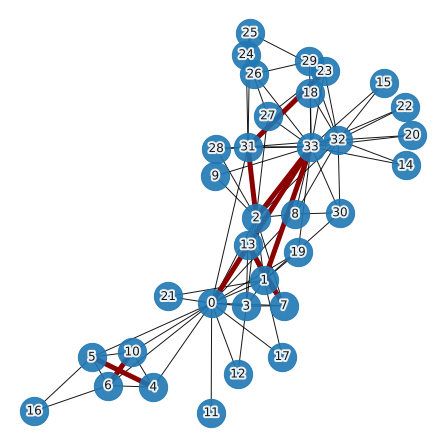

In [8]:
G = nx.karate_club_graph()
added_edges = adamic_adar_predict(G,thresh = 2,predict_method = 'thresh')
added_edges = adamic_adar_predict(G,n_top = 8,predict_method = 'n_largest')
plot_with_added_edges(G,added_edges)

*Adamic-Adar tend to predict cluster connections*

# Machine Learning

In [0]:
def mask_edges(G, n_removed = 25, max_iters = 1000):

    init_edges = len(G.edges())
    edges_removed = []

    for i in range(max_iters):
        edges = list(G.edges())
        n_edges = len(edges)
        e = np.random.choice(range(n_edges))
        u,v = edges[e][0],edges[e][1]
        G.remove_edge(u,v)

        if not nx.is_connected(G):
            G.add_edge(u,v)
        else:
            edges_removed.append([u,v])

        if (init_edges - n_edges) == n_removed:
            print('Successfully hide {} edges.'.format(n_removed))
            break
        
        if i == max_iters -1:
            print('Unable to hide enough edges, only {} edges masked.'.format(len(edges_removed)))

    return G, np.array(edges_removed)


def check_masking(G,G_mask):
    with plt.xkcd():
        figsize(12,6)
        plt.subplot(1,2,1)
        nx.draw(G, with_labels = True,alpha = 0.8)
        plt.title('Original Graph')
        plt.subplot(1,2,2)
        nx.draw(G_mask, with_labels = True,alpha = 0.8)
        plt.title('Masked Graph')
    plt.show()


def negative_sampling(G,G_mask, n_negative = -1):

    '''
        Perform negative sampling
        Parameters:
        --------
            G: networkx graph
            G_masked: networkx graph with some edges masked
            n_negative: number of negative samples, -1 for under sampling

        Returns:
        --------
            tuple of numpy arrays (train_positives, train_negatives)
            each contains array of edges
    '''
    train_positives = np.array(G_mask.edges())
    all_negatives = np.array(list(nx.non_edges(G)))
    if n_negative  < 0:
        n_negative = abs(n_negative) * len(train_positives)

    n_negative = min(len(all_negatives)-1,n_negative)
    idx_neg = np.random.choice(range(len(all_negatives)),size = n_negative)
    train_negatives = all_negatives[idx_neg]
    return (train_positives, train_negatives)

In [0]:
def generate_dataset(G, n_removed = 25,n_negative = -1,max_iters = 1000):
    G_mask, edges_removed = mask_edges(G.copy(),n_removed,max_iters)
    check_masking(G,G_mask)
    pos,neg = negative_sampling(G,G_mask,n_negative)
    print('Number of positive examples: {}\nNumber of negative examples: {}'.format(len(pos),len(neg)))
    return{
        'network':G,
        'masked_graph':G_mask,
        'edges_removed': edges_removed,
        'positive':pos,
        'negative':neg
    }

# Test code
# G = nx.karate_club_graph()
# G_mask, edges_removed = mask_edges(G.copy(),25,1000)
# check_masking(G,G_mask)
# pos,neg = negative_sampling(G,G_mask,-1)
# print('Number of positive examples: {}\nNumber of negative examples: {}'.format(len(pos),len(neg)))

Successfully hide 33 edges.


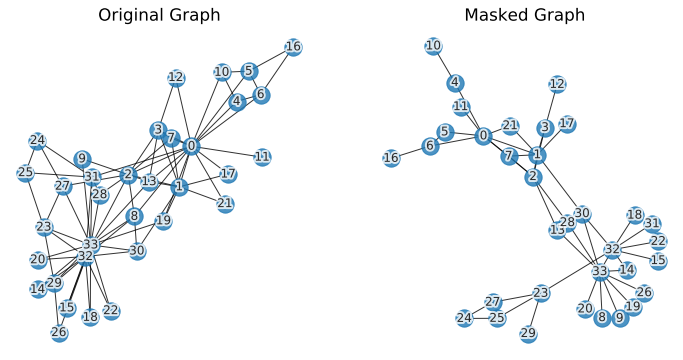

Number of positive examples: 44
Number of negative examples: 88


In [39]:
G = nx.karate_club_graph()
data = generate_dataset(G,33,-2)
n_positive = len(data['positive'])
n_negative = len(data['negative'])

In [0]:
def ml_preprocess(data, category = 'positive'):

    edge_list = data[category]
    graph = data['masked_graph']
    common_neighbors = np.array([len(list(nx.common_neighbors(graph,u,v))) for u,v in edge_list])
    pr = nx.pagerank(graph)
    pr_scores = np.array([[pr[u], pr[v]]  for u,v in edge_list])
    adar = nx.adamic_adar_index(graph, edge_list)
    adar_scores = np.array(list(adar))[:,-1]

    features = np.c_[edge_list,common_neighbors,pr_scores, adar_scores]
    if category == 'positive' or category == 'edges_removed':
        labels = np.ones(len(edge_list))

    if category =='negative':
        labels = np.zeros(len(edge_list))
    return  features, labels


In [0]:
features_neg,labels_neg = ml_preprocess(data,'negative')

train_features_pos,train_labels_pos = ml_preprocess(data,'positive')
train_features_neg, train_labels_neg = features_neg[:n_positive],labels_neg[:n_positive]

holdout_features_pos, holdout_labels_pos = ml_preprocess(data,'edges_removed')
holdout_features_neg, holdout_labels_neg = features_neg[n_positive:],labels_neg[n_positive:]

trainset = pd.DataFrame(np.r_[np.c_[train_features_pos,train_labels_pos] ,np.c_[train_features_neg,train_labels_neg]],
                         columns = ['v1','v2','n_overlap_neis','pr1','pr2','adar','label'])
trainset = trainset.iloc[np.random.permutation(np.arange(len(trainset))),:]

holdoutset = pd.DataFrame(np.r_[np.c_[holdout_features_pos,holdout_labels_pos] ,np.c_[holdout_features_neg,holdout_labels_neg]],
                         columns = ['v1','v2','n_overlap_neis','pr1','pr2','adar','label'])

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
scaler = StandardScaler()

feature_names = ['n_overlap_neis', 'pr1', 'pr2', 'adar']
X = trainset.loc[:,feature_names].values
Y = trainset['label'].values
X = scaler.fit_transform(X)

lr = LogisticRegression(C = 0.01)
# lr = RandomForestClassifier(n_estimators = 2000,max_depth = 2,min_samples_split = 8)
lr.fit(X,Y)
train_acc = lr.score(X,Y)

X_test = holdoutset.loc[:,feature_names].values
Y_test = holdoutset['label'].values
X_test = scaler.fit_transform(X_test)
test_acc = lr.score(X_test,Y_test)


print('Training set accuracy: {}\nTest set accuracy: {}'.format(train_acc,test_acc))

Training set accuracy: 0.7727272727272727
Test set accuracy: 0.7307692307692307


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
proba = lr.predict_proba(X_test)
preds = proba[:,1] > 0.57

In [66]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82        44
         1.0       1.00      0.44      0.61        34

    accuracy                           0.76        78
   macro avg       0.85      0.72      0.72        78
weighted avg       0.83      0.76      0.73        78



In [67]:
confusion_matrix(Y_test, preds)

array([[44,  0],
       [19, 15]])

In [68]:
auc = roc_auc_score(Y_test,proba[:,1])
print("Testset auc score: {}".format(auc))

Testset auc score: 0.8288770053475936


In [0]:
predicted_edges = holdoutset.loc[preds.astype(bool),['v1','v2']].astype('int').values

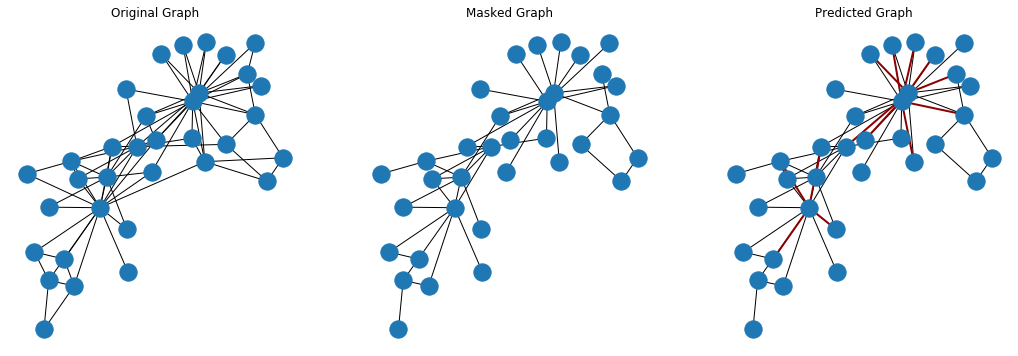

In [70]:
g = nx.karate_club_graph()
pos = nx.spring_layout(g)

figsize(18,6)
plt.subplot(1,3,1)
nx.draw(g,pos = pos)
plt.title('Original Graph')
plt.subplot(1,3,2)
nx.draw(data['masked_graph'],pos = pos)
plt.title('Masked Graph')
plt.subplot(1,3,3)
nx.draw(data['masked_graph'],pos = pos)
nx.draw_networkx_edges(data['masked_graph'],pos = pos,edgelist = predicted_edges.tolist(),edge_color = 'darkred',width = 2)
plt.title('Predicted Graph')
plt.show()

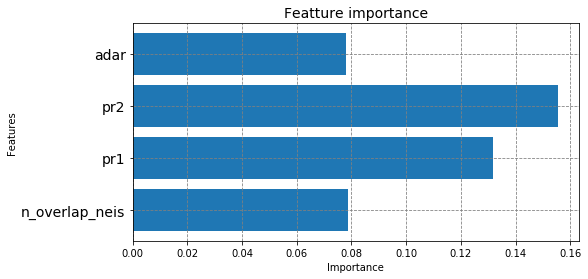

In [97]:
importance = lr.coef_[0]
figsize(8,4)
plt.barh(np.arange(len(importance)),width = importance)
plt.yticks(np.arange(len(importance)),feature_names,fontsize = 14)
plt.title("Featture importance",fontsize = 14)
plt.grid(True,linestyle = '--',color = 'gray')
plt.ylabel("Features")
plt.xlabel('Importance')
plt.show()

*Conclusion: A famous person involved, with some common friend, tend to have an edge.*